In [1]:
import logging; logging.basicConfig(level=logging.DEBUG)

from IPython.display import display
import dropbot as db
import numpy as np
import pandas as pd
import si_prefix as si
import matplotlib as mpl
import matplotlib.pyplot
import matplotlib.ticker
%matplotlib inline


F_formattter = mpl.ticker.FuncFormatter(lambda x, *args: '%sF' % si.si_format(x))
V_formattter = mpl.ticker.FuncFormatter(lambda x, *args: '%sV' % si.si_format(x))

def measure_capacitance(self, n_samples=50):
    df_volts = pd.DataFrame({'volts':
                             self.analog_reads_simple(11, n_samples) *
                             3.3 / 2**16})
    v_gnd = np.mean(df_volts)
    v_abs = np.abs(df_volts - v_gnd)
    v_abs_mean = np.mean(v_abs)
    filter_th = v_abs_mean * 1.5
    v_filtered_mean = np.mean(v_abs[v_abs < filter_th])['volts']
    volts_description = df_volts['volts'].describe()
    amplitude = .5 * (volts_description['75%'] - volts_description['25%'])
    return df_volts, amplitude, v_filtered_mean

try:
    proxy.terminate()
except:
    pass
proxy = db.SerialProxy()

proxy.hv_output_enabled = True

N = 4
s_channel_states = pd.Series(N * [1], index=range(N))
channel_states = np.zeros(proxy.number_of_channels, dtype=int)
channel_states[s_channel_states.index] = s_channel_states
proxy.state_of_channels = channel_states
proxy.properties

DEBUG:trollius:Using proactor: IocpProactor
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM15 (baudrate=115200)
DEBUG:serial_device.threaded:Open `COM15` and monitor connection status
DEBUG:serial_device.threaded:connection_made: `COM15` `<ReaderThread(Thread-11, started daemon 13540)>`
DEBUG:base_node_rpc.proxy:Wait for connection to port COM15
INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM15


base_node_software_version                                       0.40.3
package_name                                                    dropbot
display_name                                                    DropBot
manufacturer                                              Sci-Bots Inc.
url                           http://gitlab.com/sci-bots/dropbot.py.git
software_version                                                 1.40.4
dtype: object

# Run the following cell to measure capacitance and compare amplitude calculation methods

     percentile_diff_amplitude: 35.7 mV
               v_filtered_mean: 35.9 mV


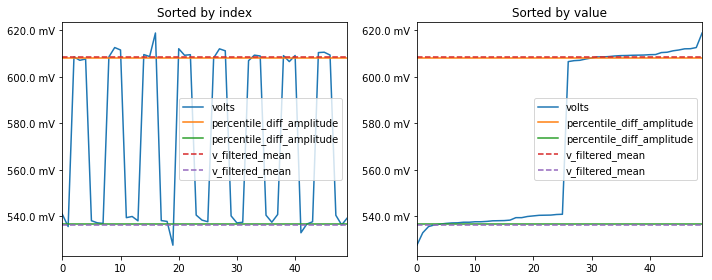

In [2]:
fig, axes = mpl.pyplot.subplots(1, 2, figsize=(10, 4))
df_volts, percentile_diff_amplitude, v_filtered_mean = measure_capacitance(proxy)
axis = axes[0]
axis = df_volts.plot(ax=axis)
volts_mean = df_volts.mean() 
axis.set_title('Sorted by index')
values = {'v_filtered_mean': v_filtered_mean,
          'percentile_diff_amplitude': percentile_diff_amplitude}

axis = axes[1]
df_volts.sort_values('volts').reset_index(drop=True).plot(ax=axis)
axis.set_title('Sorted by value')

for axis in axes:
    for i, (key_i, value_i) in enumerate(values.iteritems()):
        axis.plot(axis.get_xlim(), 2 * [volts_mean + value_i], linestyle='-' * (i + 1), label=key_i)
        axis.plot(axis.get_xlim(), 2 * [volts_mean - value_i], linestyle='-' * (i + 1), label=key_i)
    axis.legend()
    axis.yaxis.set_major_formatter(V_formattter)

for key_i, value_i in values.iteritems():
    print '%30s: %sV' % (key_i, si.si_format(value_i))

fig.tight_layout()

# Run the following cell to compare repeated capacitance measurements using different amplitude calculation methods

,filtered_mean,percentile_difference
count,5.000000e+01,5.000000e+01
mean,1.210067e-10,1.278946e-10
std,9.945172e-12,8.334772e-13
min,9.419690e-11,1.258982e-10
25%,1.156625e-10,1.275675e-10
50%,1.259661e-10,1.280141e-10
75%,1.281385e-10,1.284711e-10
max,1.307972e-10,1.293746e-10


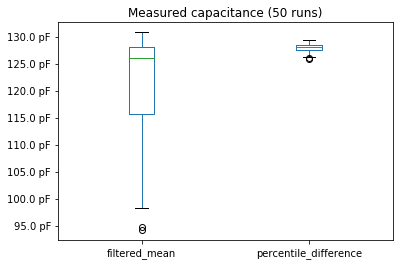

In [3]:
actuated_channels_count = 10
s_channel_states = pd.Series(actuated_channels_count * [1],
                             index=range(actuated_channels_count))
channel_states = np.zeros(proxy.number_of_channels, dtype=int)
channel_states[s_channel_states.index] = s_channel_states
proxy.state_of_channels = channel_states

# Amplitude calculation methods.
methods = ['filtered_mean', 'percentile_difference']

# Number of measurements to run for each amplitude calculation method.
N = 50
df_capacitances = pd.DataFrame([proxy.measure_capacitance(amplitude=methods)
                                for i in xrange(N)])
display(df_capacitances.describe())

axis = df_capacitances.plot(kind='box')
axis.set_title('Measured capacitance (%s runs)' % N)
axis.yaxis.set_major_formatter(F_formattter)